In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from scipy.optimize import curve_fit
import numpy.typing as npt
import typing 
import multiprocessing.pool




## Input Processing

Import the file skipping the first 18 row
and then select the column and transpose

In [2]:
file_name = "../Data/RLC_time.csv"
file = "../Output/RLC_analysis"
data = np.genfromtxt(file_name, skip_header=18, delimiter=",", dtype=np.float64)

for element in data[:10]:
    print(element)

[      nan       nan       nan  2.16e-06 -2.24e-01       nan]
[      nan       nan       nan  2.18e-06 -2.08e-01       nan]
[     nan      nan      nan  2.2e-06 -2.0e-01      nan]
[      nan       nan       nan  2.22e-06 -1.76e-01       nan]
[      nan       nan       nan  2.24e-06 -1.60e-01       nan]
[      nan       nan       nan  2.26e-06 -1.44e-01       nan]
[      nan       nan       nan  2.28e-06 -1.36e-01       nan]
[     nan      nan      nan  2.3e-06 -1.2e-01      nan]
[      nan       nan       nan  2.32e-06 -1.04e-01       nan]
[      nan       nan       nan  2.34e-06 -8.80e-02       nan]


In [3]:
t_data, V_data = data.T[3:5]
for x ,y in tuple(zip(t_data,V_data)):
    print(x,y)

2.16e-06 -0.224
2.18e-06 -0.208
2.2e-06 -0.2
2.22e-06 -0.176
2.24e-06 -0.16
2.26e-06 -0.144
2.28e-06 -0.136
2.3e-06 -0.12
2.32e-06 -0.104
2.34e-06 -0.088
2.36e-06 -0.072
2.38e-06 -0.056
2.4e-06 -0.04
2.42e-06 -0.024
2.44e-06 -0.008
2.46e-06 0.008
2.48e-06 0.024
2.5e-06 0.032
2.52e-06 0.048
2.54e-06 0.064
2.56e-06 0.08
2.58e-06 0.096
2.6e-06 0.104
2.62e-06 0.12
2.64e-06 0.136
2.66e-06 0.152
2.68e-06 0.168
2.7e-06 0.184
2.72e-06 0.2
2.74e-06 0.208
2.76e-06 0.224
2.78e-06 0.24
2.8e-06 0.256
2.82e-06 0.264
2.84e-06 0.28
2.86e-06 0.296
2.88e-06 0.312
2.9e-06 0.32
2.92e-06 0.336
2.94e-06 0.344
2.96e-06 0.36
2.98e-06 0.376
3e-06 0.384
3.02e-06 0.4
3.04e-06 0.408
3.06e-06 0.424
3.08e-06 0.44
3.1e-06 0.448
3.12e-06 0.464
3.14e-06 0.472
3.16e-06 0.488
3.18e-06 0.504
3.2e-06 0.512
3.22e-06 0.52
3.24e-06 0.536
3.26e-06 0.544
3.28e-06 0.552
3.3e-06 0.568
3.32e-06 0.584
3.34e-06 0.592
3.36e-06 0.6
3.38e-06 0.608
3.4e-06 0.616
3.42e-06 0.632
3.44e-06 0.64
3.46e-06 0.656
3.48e-06 0.664
3.5e-06 0.672
3

## Fit Function


In [4]:
def fitF(x, A: np.float64, B: np.float64, C: np.float64):
    '''Prototype of the function to fit

    Args:
        x (np.float64): Independent Variable Corresponding to t
        A (np.float64): First Parameter corresponding to v0
        B (np.float64): Second Parameter corresponding to lower omega
        C (np.float64): Third Parameter corresponding to lower delta

    Returns:
        np.float64: Dependent Variable corresponding to V
    '''
    omega = np.sqrt(abs(B**2-C**2))
    y = A*np.exp(-C*x)*(C/omega*np.sin(omega*x)-np.cos(omega*x))
    return y

In [5]:
def fitFgen(x, A: np.float64, B: np.float64, C: np.float64, S: np.float64, Q: np.float64)-> np.float64:
    '''Prototype of the function to fit

    Args:
        t (np.float64): Independent Variable Corresponding to t
        A (np.float64): First Parameter corresponding to v0
        B (np.float64): Second Parameter corresponding to lower omega
        C (np.float64): Third Parameter corresponding to lower delta
        S (np.float64): Parameter corresponding to a shift in the x direction
        Q (np.float64): Parameter corresponding to a shift in the y direction



    Returns:
        np.float64: Dependent Variable corresponding to V
    '''
    x = x-S
    omega = np.sqrt(abs(B**2-C**2))
    y = A*np.exp(-C*x)*(C/omega*np.sin(omega*x)-np.cos(omega*x))+Q
    return y

In [6]:
def profi2D(axis,mappa,step =100):
    if axis == 1 :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
    if axis == 2 :
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
    if axis == 3 :
        mappa2D = np.array([[np.min(mappa[a,b,:]) for a in range(step)] for b in range(step)])
    return mappa2D

def profi1D(axis, mappa, step =100):
    if 1 in axis :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
#        print('1')
        if 2 in axis:
            mappa1D = np.array([np.min(mappa2D[b,:]) for b in range(step)])
#            print('2')
        if 3 in axis:
            mappa1D = np.array([np.min(mappa2D[:,c]) for c in range(step)])
#            print('3')
    else :
#        print('2-3')
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
        mappa1D = np.array([np.min(mappa2D[a,:]) for a in range(step)])
    return mappa1D

## Plot Parameters

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')  # More modern look than ROOT style
params = {
    'figure.figsize': (8, 6),
    'axes.labelsize': 12,
    'figure.titlesize': 16,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'legend.fontsize': 11,
    'legend.framealpha': 0.8,
    'legend.loc': 'best',
    'figure.dpi': 120,
    'savefig.dpi': 150,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.constrained_layout.use': True
}
plt.rcParams.update(params)

# More vibrant color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                                               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])


## Init Parameter

In [8]:
Ainit = 2
Binit = 6e5
Cinit = 8e4
Sinit = 0
Qinit = -0.018

init5 = [Ainit,Binit,Cinit,Sinit,Qinit]
init3 = [Ainit,Binit,Cinit]


## Data Errors

In [9]:
# Assumed reading errors
err_reading_V = 0.02*0.41  # errore di lettura dell'oscilloscopio nel voltaggio 1/10 div * distr.triangolare
err_scale_V = 0.03*0.41 #  errore percentuale dell'oscilloscopio nel voltaggio 3% * distr.triangolare
err_reading_t = 0.5e-6*0.41  # errore di lettura dell'oscilloscopio nel tempo 1/10 div * distr.triangolare

err_V = np.sqrt((err_reading_V)**2 + (err_scale_V * V_data)**2)
err_t = err_reading_t
print(err_V)

[0.0086505  0.00858984 0.00856105 ... 0.00820059 0.00820059 0.00820059]


# Plot Raw Data

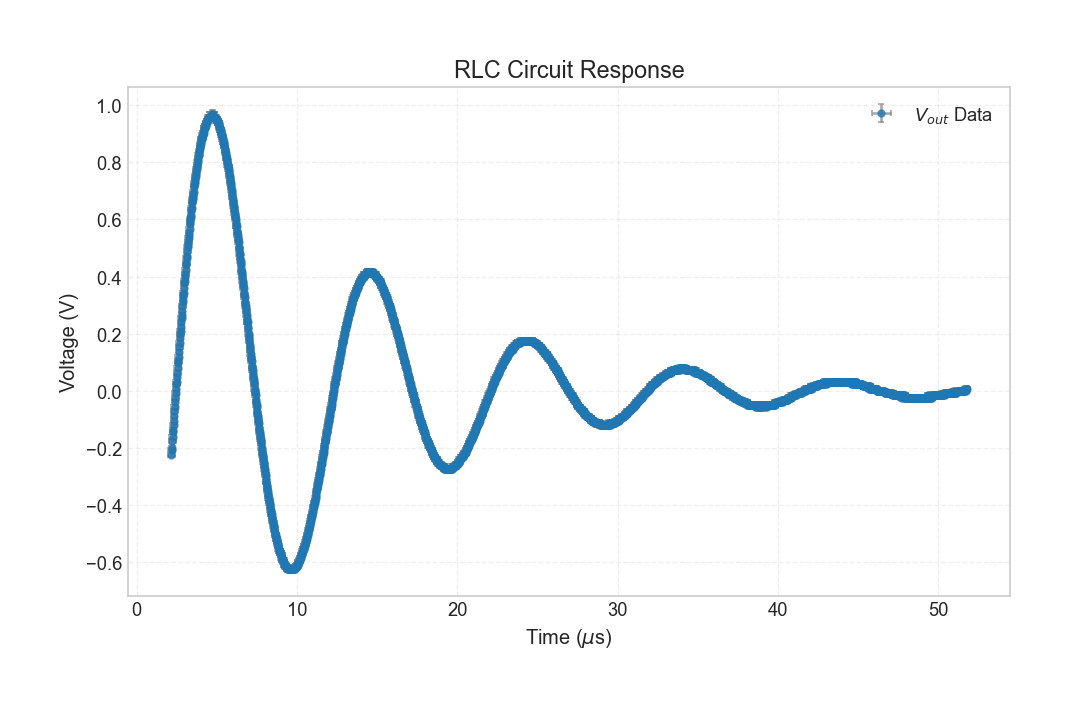

In [10]:
def plot_raw_data():
    """Plot the raw data with improved styling"""
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(t_data*1e6, V_data, yerr=err_V, xerr=err_t*1e6, 
                fmt='o', label=r'$V_{out}$ Data', ms=4, color='#1f77b4',
                alpha=0.7, ecolor='gray', capsize=2)
    
    ax.set_xlabel(r'Time ($\mu$s)', fontsize=12)
    ax.set_ylabel(r'Voltage (V)', fontsize=12)
    ax.set_title('RLC Circuit Response', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.savefig(f'{file}_raw_data.png')
    plt.close()
    return fig
plot_raw_data()

## First Fit

In [11]:
def plot_first_fit(popt):
    """Plot the first fit with improved styling and consistent colors"""
    x_fit = np.linspace(min(t_data), max(t_data), 1000)
    residuals = V_data - fitFgen(t_data, *popt)
    
    # Define consistent colors
    fit_color = '#d62728'  # Red for both fit and residuals
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True, 
                             gridspec_kw={'height_ratios': [3, 1]})
    
    # Main plot
    ax = axes[0]
    ax.errorbar(t_data*1e6, V_data, yerr=err_V, xerr=err_t*1e6, 
                fmt='o', label=r'$V_{out}$ Data', ms=4, color=fit_color,
                alpha=0.7, ecolor='gray', capsize=2)
    
    ax.plot(x_fit*1e6, fitFgen(x_fit, *popt), label='Best Fit', 
            linestyle='-', color=fit_color, linewidth=2)
    
    ax.set_ylabel('Voltage (V)', fontsize=12)
    ax.set_title('RLC Circuit Response with Fit', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Residuals plot - now with consistent color
    ax = axes[1]
    ax.errorbar(t_data*1e6, residuals, yerr=err_V, fmt='o', 
                ms=3, color=fit_color, alpha=0.8, ecolor='gray', capsize=2)
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel(r'Time ($\mu$s)', fontsize=12)
    ax.set_ylabel('Residuals (V)', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'{file}_first_fit.png')
    plt.close()
    return fig

============== BEST FIT with SciPy ====================
A = (1.422e+00 +/- 2.0e-03)
B = (6.45974e+05 +/- 1.0e+02) Hz
C = (8.607e+04 +/- 1.2e+02) Hz
S = (2.2091e-07 +/- 1.6e-09) s
Q = (-2.9577e-04 +/- -3.0e-04) V


C:\Users\bagno\AppData\Local\Temp\ipykernel_13932\1104940411.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


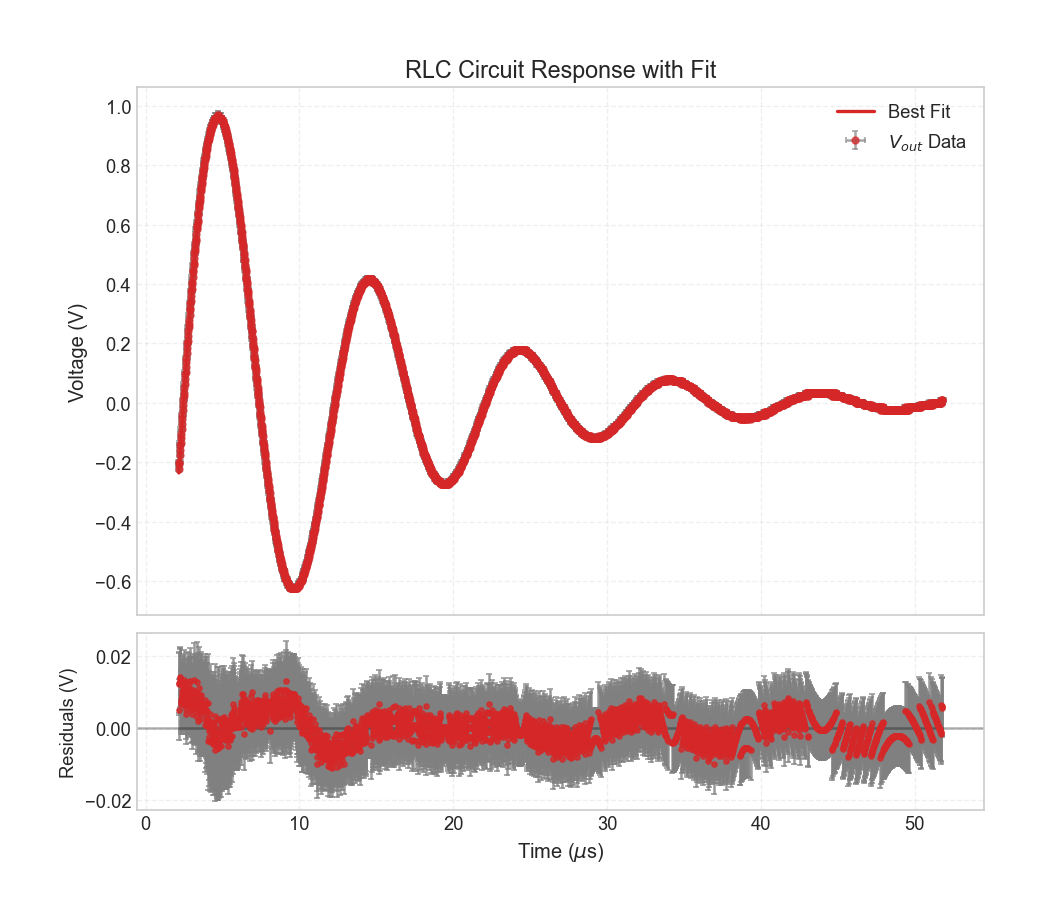

In [12]:
popt, pcov= curve_fit(fitFgen,t_data,V_data, p0 = init5,method = "lm",sigma = err_V, absolute_sigma= True) 
A_BF, B_BF, C_BF, S_BF, Q_BF = popt #Best Parameter
eA_BF, eB_BF, eC_BF, eS_BF, eQ_BF = np.sqrt(np.diag(pcov)) #Error associated with each parameter

print("============== BEST FIT with SciPy ====================")
print(r'A = ({a:.3e} +/- {b:.1e})'.format(a=A_BF,b=eA_BF))
print(r'B = ({c:.5e} +/- {d:.1e}) Hz'.format(c=B_BF, d=eB_BF))
print(r'C = ({e:.3e} +/- {f:.1e}) Hz'.format(e=C_BF, f=eC_BF))
print(r'S = ({g:.4e} +/- {h:.1e}) s'.format(g=S_BF, h=eS_BF))
print(r'Q = ({i:.4e} +/- {l:.1e}) V'.format(i=Q_BF, l=Q_BF))
print("=======================================================")
plot_first_fit(popt)


## S and Q Correction

In [13]:
V_data = V_data[t_data>S_BF]-Q_BF
err_V = err_V[t_data >S_BF]
t_data = t_data[t_data > S_BF]-S_BF
print(err_V[:10])

[0.0086505  0.00858984 0.00856105 0.00848094 0.00843285 0.00838911
 0.00836889 0.00833178 0.00829918 0.00827113]


## Second Fit

In [14]:
def plot_second_fit(popt, chi2):
    """Plot the second fit with consistent styling to the first fit"""
    x_fit = np.linspace(min(t_data), max(t_data), 1000)
    residuals = V_data - fitF(t_data, *popt)
    
    # Define consistent colors
    fit_color = '#d62728'  # Red for both fit and residuals
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True, 
                             gridspec_kw={'height_ratios': [3, 1]})
    
    # Main plot
    ax = axes[0]
    ax.errorbar(t_data * 1e6, V_data, yerr=err_V, xerr=err_t * 1e6, 
                fmt='o', label=r'$V_{out}$ Data', ms=4, color=fit_color,
                alpha=0.7, ecolor='gray', capsize=2)
    
    ax.plot(x_fit * 1e6, fitF(x_fit, *popt), label='Best Fit', 
            linestyle='-', color=fit_color, linewidth=2)
    
    ax.set_ylabel('Voltage (V)', fontsize=12)
    ax.set_title('RLC Circuit Response with Second Fit', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Residuals plot - consistent with first fit
    ax = axes[1]
    ax.errorbar(t_data * 1e6, residuals, yerr=err_V, fmt='o', 
                ms=3, color=fit_color, alpha=0.8, ecolor='gray', capsize=2)
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel(r'Time ($\mu$s)', fontsize=12)
    ax.set_ylabel('Residuals (V)', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'{file}_second_fit.png')
    plt.close()
    return fig

============== BEST FIT with SciPy ====================
A = (1.422e+00 +/- 1.9e-03)
B = (6.45974e+05 +/- 6.2e+01) Hz
C = (8.607e+04 +/- 1.1e+02) Hz
chisq = 545.60
chisqrid = 0.22009
Covariance Matrix:
[[    0.0000037    -0.0012174     0.178065 ]
 [   -0.0012174  3786.0822245     2.8316013]
 [    0.178065      2.8316013 13087.7791817]]


C:\Users\bagno\AppData\Local\Temp\ipykernel_13932\440670316.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


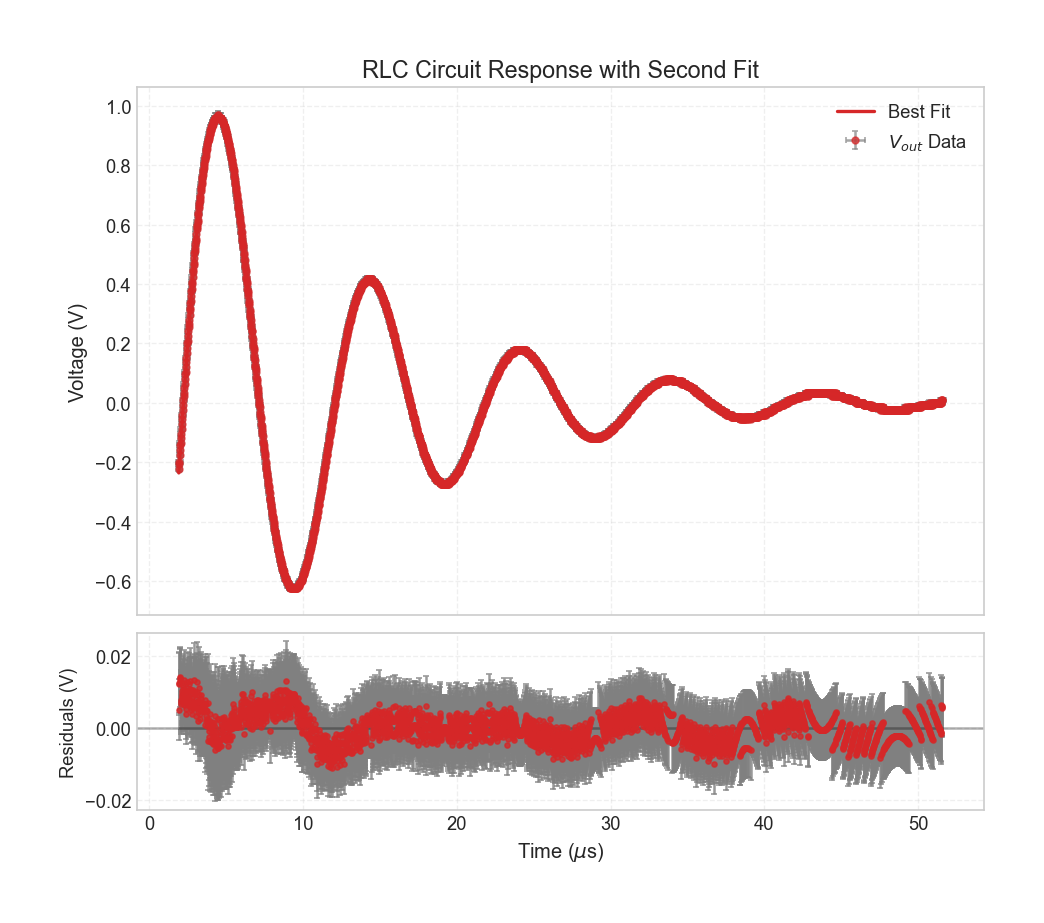

In [15]:
popt , pcov = curve_fit(fitF, t_data, V_data, p0 = init3, sigma = err_V, absolute_sigma=True,method="lm")
A_BF, B_BF, C_BF = popt #Best Parameter
eA_BF, eB_BF, eC_BF= np.sqrt(np.diag(pcov)) #Error associated with each parameter
r = V_data - fitF(t_data, *popt)
chisq = np.sum((r/err_V)**2)
N = len(r)
df = N-3
chisqrid = chisq/df

print("============== BEST FIT with SciPy ====================")
print(r'A = ({a:.3e} +/- {b:.1e})'.format(a=A_BF,b=eA_BF))
print(r'B = ({c:.5e} +/- {d:.1e}) Hz'.format(c=B_BF, d=eB_BF))
print(r'C = ({e:.3e} +/- {f:.1e}) Hz'.format(e=C_BF, f=eC_BF))
print(r'chisq = {g:.2f}'.format(g=chisq))
print(r'chisqrid = {h:.5f}'.format(h=chisqrid))
print("=======================================================")

#Print pcov matrix
print("Covariance Matrix:")
print(np.array_str(pcov, precision=7, suppress_small=True))


plot_second_fit(popt, chisq)

# Metodo mappa Chi2

In [16]:
def fitchi2gen(i,j,k, func , x , y , y_err , Aset, Bset, Cset ):

    AA,BB,CC = Aset[i],Bset[j],Cset[k]
    residuals = (y - func(x,AA,BB,CC))
    chi2 = np.sum((residuals / y_err)**2)
    return chi2



In [17]:
#Estremi degli intervalli in cui calcolo il Chi2

NSI = 2
Ai , Af = A_BF - NSI*eA_BF , A_BF + NSI*eA_BF
Bi , Bf = B_BF - NSI*eB_BF , B_BF + NSI*eB_BF
Ci , Cf = C_BF - NSI*eC_BF , C_BF + NSI*eC_BF

step=100 # numero di valori per ogni intervallo
A_chi = np.linspace(Ai,Af,step)
B_chi = np.linspace(Bi,Bf,step)
C_chi = np.linspace(Ci,Cf,step)

In [18]:
item = [(i,j,k) for i in range(step) for j in range(step) for k in range(step)]


In [19]:
fitchi2 = lambda i,j,k: fitchi2gen(i,j,k,fitF, t_data, V_data, err_V, A_chi, B_chi, C_chi )

with multiprocessing.pool.ThreadPool() as pool:
    mappa = pool.starmap(fitchi2, item, chunksize=10)

In [20]:
mappa = np.array(mappa).reshape((step,step,step))
print(mappa[1,:5,:5])


[[554.04851264 553.95937228 553.8797924  553.80977043 553.74930383]
 [553.88513493 553.79596879 553.71636313 553.64631536 553.58582295]
 [553.72503205 553.63583985 553.55620809 553.48613424 553.42561572]
 [553.56820402 553.47898544 553.39932731 553.32922706 553.26868214]
 [553.41465083 553.32540558 553.24572077 553.17559384 553.11502222]]


In [21]:
chi2_min = np.min(mappa)
argchi2_min = np.unravel_index(np.argmin(mappa),mappa.shape)
i, j , k = argchi2_min
r = V_data-fitF(t_data, A_chi[i], B_chi[j], C_chi[k])
chisq = np.sum((r/err_V)**2)
print(chi2_min,argchi2_min,chisq)



545.5963945482598 (49, 50, 49) 545.5963945482598


In [22]:
#Calcolo Profilazione 2D
chi2D = profi2D(1,mappa)
Achi2D = profi2D(2,mappa) 

#Calcolo Profilazioni 1D
prof_B = profi1D([1,3],mappa)
prof_C = profi1D([1,2],mappa)   
prof_A = profi1D([2,3],mappa)    

In [23]:
lvl = chi2_min+1. # 2.3 (2parametri) # 3.8 (3parametri)
diff_B = abs(prof_B-lvl)
diff_C = abs(prof_C-lvl)
diff_A = abs(prof_A-lvl)

B_dx = np.argmin(diff_B[B_chi<B_BF]) # minimo di B per valori inferiori al BF
B_sx = np.argmin(diff_B[B_chi>B_BF])+len(diff_B[B_chi<B_BF]) # minimo di B per valori superiori al BF
C_dx = np.argmin(diff_C[C_chi<C_BF])
C_sx = np.argmin(diff_C[C_chi>C_BF])+len(diff_C[C_chi<C_BF])
A_dx = np.argmin(diff_A[A_chi<A_BF])
A_sx = np.argmin(diff_A[A_chi>A_BF])+len(diff_A[A_chi<A_BF])
#print(B_dx,B_sx,C_dx,C_sx,A_dx,A_sx)

# Facendo la differenza rispetto al BF ottengo gli errori a dx e a sx del BF
errA = A_chi[argchi2_min[0]]-A_chi[A_dx]
errAA = A_chi[A_sx]-A_chi[argchi2_min[0]]
errB = B_chi[argchi2_min[1]]-B_chi[B_dx] 
errBB = B_chi[B_sx] -B_chi[argchi2_min[1]]
errC = C_chi[argchi2_min[2]]-C_chi[C_dx]
errCC = C_chi[C_sx]-C_chi[argchi2_min[2]]

print("============== BEST FIT with chi2 ====================")
print(r'A = ({a:.3e} - {b:.1e} + {c:.1e})'.format(a=A_chi[argchi2_min[0]],b=errA,c=errAA))
print(r'B = ({d:.5e} - {e:.1e} + {f:.1e}) Hz'.format(d=B_chi[argchi2_min[1]] , e=errB , f=errBB))
print(r'C = ({g:.3e} - {h:.1e} + {n:.1e}) Hz'.format(g=C_chi[argchi2_min[2]], h=errC,  n=errCC))
print(r'chisq = {m:.2f}'.format(m=np.min(mappa)))
print("=======================================================")

============== BEST FIT with chi2 ====================
A = (1.421e+00 - 1.9e-03 + 1.9e-03)
B = (6.45975e+05 - 6.2e+01 + 6.0e+01) Hz
C = (8.606e+04 - 1.1e+02 + 1.2e+02) Hz
chisq = 545.60


In [30]:
def plot_chi2_heatmap(chi2_min, B_chi, C_chi, chi2D, prof_B, prof_C, B_dx, B_sx, C_dx, C_sx):
    """Plot chi-squared heatmap with improved styling"""
    # Create a modern colormap
    cmap = plt.cm.viridis_r
    
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 3],
                          hspace=0.05, wspace=0.05)
    
    ax_main = fig.add_subplot(gs[0, 1])
    ax_top = fig.add_subplot(gs[0, 0], sharey=ax_main)
    ax_right = fig.add_subplot(gs[1, 1], sharex=ax_main)
    
    # Empty subplot for aesthetics
    ax_empty = fig.add_subplot(gs[1, 0])
    ax_empty.set_visible(False)
    
    # Main contour plot
    contour_levels = np.linspace(chi2_min, chi2_min + 10, 50)
    cf = ax_main.contourf(B_chi, C_chi, chi2D, 
                          levels=contour_levels, cmap=cmap)
    
    # Add contour lines at specific chi² values
    contour_lines = ax_main.contour(B_chi, C_chi, chi2D, 
                                  levels=[chi2_min+1, chi2_min+2.3, chi2_min+3.8],
                                  colors='black', linewidths=1, alpha=0.7)
    ax_main.clabel(contour_lines, inline=True, fontsize=9, fmt='%.1f')
    
    # Mark the minimum and add parameter confidence intervals
    ax_main.plot(B_chi[np.argmin(prof_B)], C_chi[np.argmin(prof_C)], 
               'x', color='red', markersize=8, label=f'Min χ²: {chi2_min:.2f}')
    
    # Add horizontal and vertical lines at confidence intervals
    ax_main.axhline(C_chi[C_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axhline(C_chi[C_dx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(B_chi[B_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(B_chi[B_dx], color='gray', ls='--', alpha=0.7)
    
    # B profile plot
    ax_right.plot(B_chi, prof_C, '-', color='#1f77b4')
    ax_right.axhline(chi2_min+1, color='red', ls='--', alpha=0.7, 
                   label='χ²+1')
    ax_right.axvline(B_chi[B_sx], color='gray', ls='--')
    ax_right.axvline(B_chi[B_dx], color='gray', ls='--')
    ax_right.set_xlabel(r'$\omega_0$ (Hz)', fontsize=12)
    ax_right.set_ylabel('χ²', fontsize=10)
    
    # C profile plot
    ax_top.plot(prof_B, C_chi, '-', color='#1f77b4')
    ax_top.axvline(chi2_min+1, color='red', ls='--', alpha=0.7)
    ax_top.axhline(C_chi[C_sx], color='gray', ls='--')
    ax_top.axhline(C_chi[C_dx], color='gray', ls='--')
    ax_top.set_ylabel(r' $\delta$ (Hz)', fontsize=12)  # Updated label
    
    # Make y-axis of top plot on the right
    ax_top.yaxis.tick_left()
    ax_top.yaxis.set_label_position("left")
    
    # Set limits and invert x-axis for top plot to match
    ax_top.set_xlim(chi2_min-1, chi2_min+10)
    
    # Title and colorbar
    fig.suptitle(r'χ² Analysis: $\omega_0$ vs.  $\delta$', fontsize=16)  # Updated title
    cbar = plt.colorbar(cf, ax=ax_main, shrink=0.8)
    cbar.set_label('χ²', fontsize=12)
    
    # Add legend
    ax_main.legend(loc='upper right')
    
    plt.savefig(f'{file}_chi2_heatmap.png')
    plt.close(fig)
    return fig

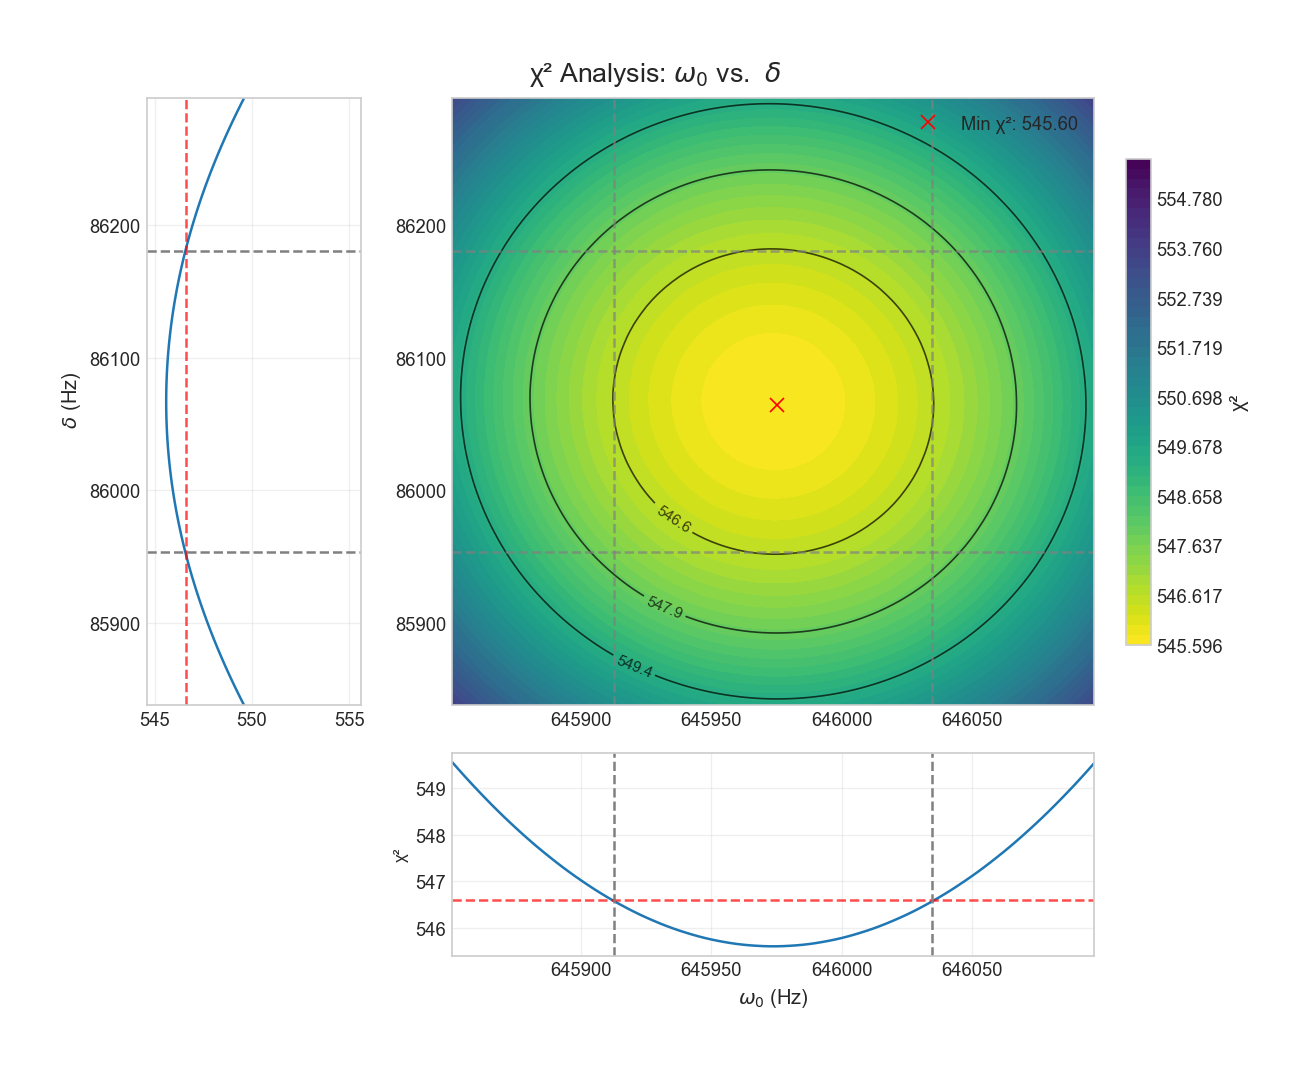

In [31]:
plot_chi2_heatmap(chi2_min, B_chi, C_chi, chi2D, prof_B, prof_C, B_dx, B_sx, C_dx, C_sx)

In [32]:
def plot_chi2_heatmap_AB(chi2_min, A_chi, B_chi, chi2D, prof_A, prof_B, A_dx, A_sx, B_dx, B_sx):
    """Plot chi-squared heatmap for A and B profiling with improved styling"""
    # Create a modern colormap
    cmap = plt.cm.viridis_r
    
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 3],
                          hspace=0.05, wspace=0.05)
    
    ax_main = fig.add_subplot(gs[0, 1])
    ax_top = fig.add_subplot(gs[0, 0], sharey=ax_main)
    ax_right = fig.add_subplot(gs[1, 1], sharex=ax_main)
    
    # Empty subplot for aesthetics
    ax_empty = fig.add_subplot(gs[1, 0])
    ax_empty.set_visible(False)
    
    # Main contour plot
    contour_levels = np.linspace(chi2_min, chi2_min + 10, 50)
    cf = ax_main.contourf(A_chi, B_chi, chi2D, 
                          levels=contour_levels, cmap=cmap)
    
    # Add contour lines at specific chi² values
    contour_lines = ax_main.contour(A_chi, B_chi, chi2D, 
                                  levels=[chi2_min+1, chi2_min+2.3, chi2_min+3.8],
                                  colors='black', linewidths=1, alpha=0.7)
    ax_main.clabel(contour_lines, inline=True, fontsize=9, fmt='%.1f')
    
    # Mark the minimum and add parameter confidence intervals
    ax_main.plot(A_chi[np.argmin(prof_A)], B_chi[np.argmin(prof_B)], 
               'x', color='red', markersize=8, label=f'Min χ²: {chi2_min:.2f}')
    
    # Add horizontal and vertical lines at confidence intervals
    ax_main.axhline(B_chi[B_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axhline(B_chi[B_dx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(A_chi[A_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(A_chi[A_dx], color='gray', ls='--', alpha=0.7)
    
    # A profile plot
    ax_right.plot(A_chi, prof_B, '-', color='#1f77b4')
    ax_right.axhline(chi2_min+1, color='red', ls='--', alpha=0.7, 
                   label='χ²+1')
    ax_right.axvline(A_chi[A_sx], color='gray', ls='--')
    ax_right.axvline(A_chi[A_dx], color='gray', ls='--')
    ax_right.set_xlabel(r'$V_0$ (V)', fontsize=12)
    ax_right.set_ylabel('χ²', fontsize=10)
    
    # B profile plot
    ax_top.plot(prof_A, B_chi, '-', color='#1f77b4')
    ax_top.axvline(chi2_min+1, color='red', ls='--', alpha=0.7)
    ax_top.axhline(B_chi[B_sx], color='gray', ls='--')
    ax_top.axhline(B_chi[B_dx], color='gray', ls='--')
    ax_top.set_ylabel(r'$\omega_0$ (Hz)', fontsize=12)


    
    # Make y-axis of top plot on the right
    ax_top.yaxis.tick_left()
    ax_top.yaxis.set_label_position("left")
    
    # Set limits and invert x-axis for top plot to match
    ax_top.set_xlim(chi2_min-1, chi2_min+10)
    
    # Title and colorbar
    fig.suptitle(r'χ² Analysis: $V_0$ vs. $\omega_0$', fontsize=16)
    cbar = plt.colorbar(cf, ax=ax_main, shrink=0.8)
    cbar.set_label('χ²', fontsize=12)
    
    # Add legend
    ax_main.legend(loc='upper right')
    
    plt.savefig(f'{file}_chi2_heatmap_AB.png')
    plt.close(fig)
    return fig

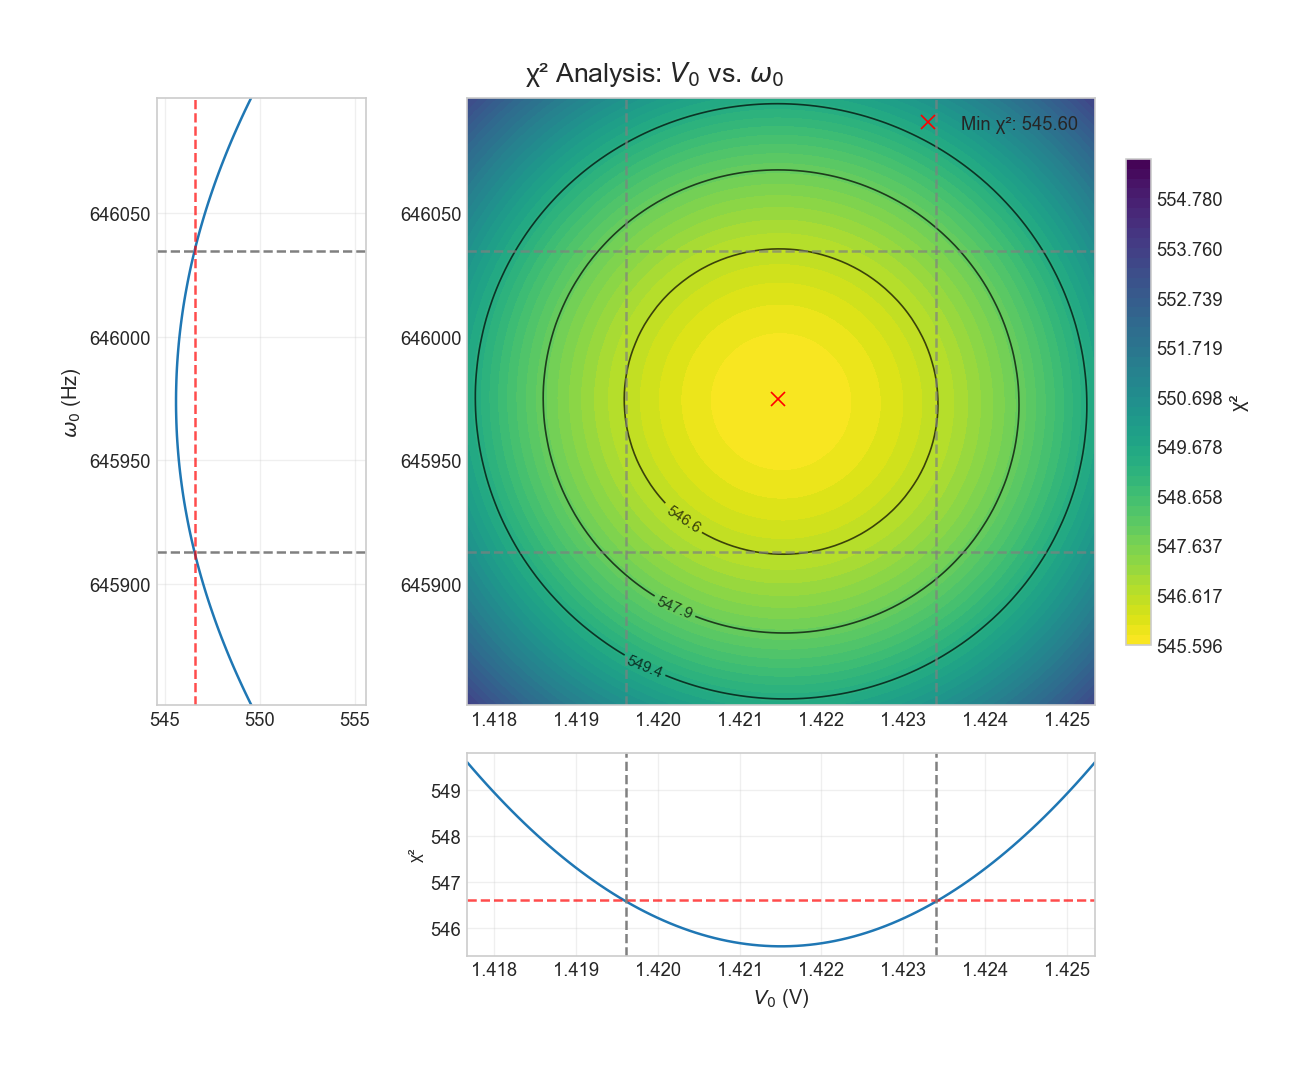

In [33]:
plot_chi2_heatmap_AB(chi2_min, A_chi, B_chi, chi2D, prof_A, prof_B, A_dx, A_sx, B_dx, B_sx)

In [34]:
def plot_chi2_heatmap_AC(chi2_min, A_chi, C_chi, chi2D, prof_A, prof_C, A_dx, A_sx, C_dx, C_sx):
    """Plot chi-squared heatmap for A and C profiling with improved styling."""
    # Create a modern colormap
    cmap = plt.cm.viridis_r

    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 3],
                          hspace=0.05, wspace=0.05)

    ax_main = fig.add_subplot(gs[0, 1])
    ax_top = fig.add_subplot(gs[0, 0], sharey=ax_main)
    ax_right = fig.add_subplot(gs[1, 1], sharex=ax_main)

    # Empty subplot for aesthetics
    ax_empty = fig.add_subplot(gs[1, 0])
    ax_empty.set_visible(False)

    # Main contour plot
    contour_levels = np.linspace(chi2_min, chi2_min + 10, 50)
    cf = ax_main.contourf(A_chi, C_chi, chi2D,
                          levels=contour_levels, cmap=cmap)

    # Add contour lines at specific chi² values
    contour_lines = ax_main.contour(A_chi, C_chi, chi2D,
                                    levels=[chi2_min+1, chi2_min+2.3, chi2_min+3.8],
                                    colors='black', linewidths=1, alpha=0.7)
    ax_main.clabel(contour_lines, inline=True, fontsize=9, fmt='%.1f')

    # Mark the minimum and add parameter confidence intervals
    ax_main.plot(A_chi[np.argmin(prof_A)], C_chi[np.argmin(prof_C)],
                 'x', color='red', markersize=8, label=f'Min χ²: {chi2_min:.2f}')

    # Add horizontal and vertical lines at confidence intervals
    ax_main.axhline(C_chi[C_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axhline(C_chi[C_dx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(A_chi[A_sx], color='gray', ls='--', alpha=0.7)
    ax_main.axvline(A_chi[A_dx], color='gray', ls='--', alpha=0.7)

    # A profile plot
    ax_right.plot(A_chi, prof_C, '-', color='#1f77b4')
    ax_right.axhline(chi2_min+1, color='red', ls='--', alpha=0.7,
                     label='χ²+1')
    ax_right.axvline(A_chi[A_sx], color='gray', ls='--')
    ax_right.axvline(A_chi[A_dx], color='gray', ls='--')
    ax_right.set_xlabel(r'$V_0$ (V)', fontsize=12)
    ax_right.set_ylabel('χ²', fontsize=10)

    # C profile plot
    ax_top.plot(prof_A, C_chi, '-', color='#1f77b4')
    ax_top.axvline(chi2_min+1, color='red', ls='--', alpha=0.7)
    ax_top.axhline(C_chi[C_sx], color='gray', ls='--')
    ax_top.axhline(C_chi[C_dx], color='gray', ls='--')
    ax_top.set_ylabel(r'$\delta$ (Hz)', fontsize=12)
    ax_top.yaxis.tick_left()
    ax_top.yaxis.set_label_position("left")

    # Make y-axis of top plot on the right
    ax_top.yaxis.tick_left()
    ax_top.yaxis.set_label_position("left")

    # Set limits and invert x-axis for top plot to match
    ax_top.set_xlim(chi2_min-1, chi2_min+10)

    # Title and colorbar
    fig.suptitle(r'χ² Analysis: $V_0$ vs. $\delta$', fontsize=16)
    cbar = plt.colorbar(cf, ax=ax_main, shrink=0.8)
    cbar.set_label('χ²', fontsize=12)

    # Add legend
    ax_main.legend(loc='upper right')

    plt.savefig(f'{file}_chi2_heatmap_AC.png')
    plt.close(fig)
    return fig

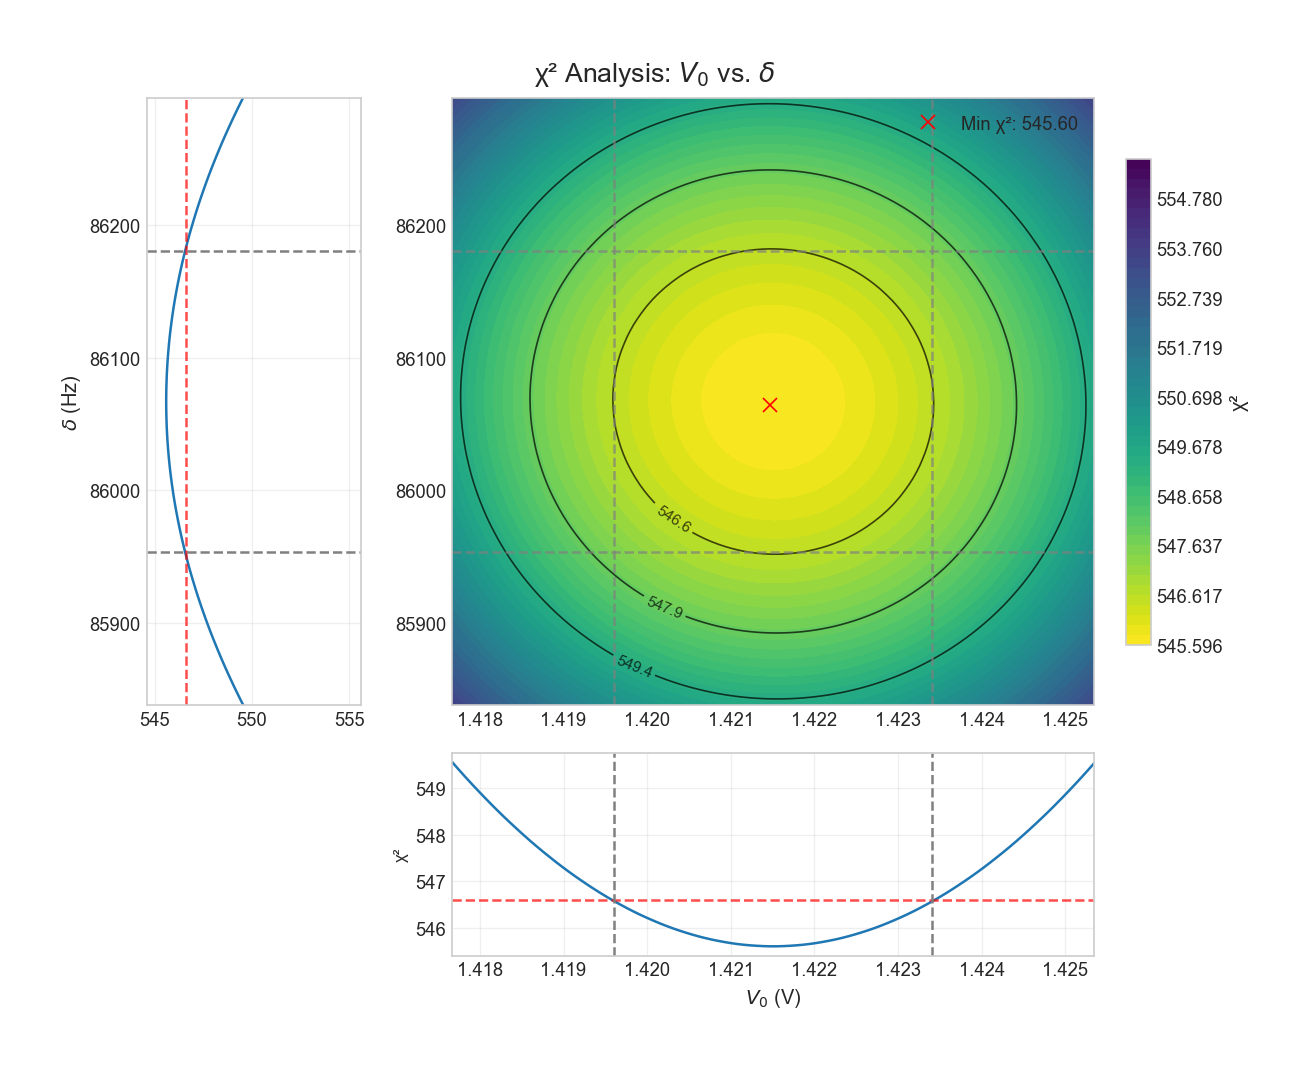

In [35]:
plot_chi2_heatmap_AC(chi2_min, A_chi, C_chi, chi2D, prof_A, prof_C, A_dx, A_sx, C_dx, C_sx)